In [43]:
import matplotlib
print(matplotlib.get_cachedir())

/data/ephemeral/home/.cache/matplotlib


In [44]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
from PIL import Image
import cv2

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import torch
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

import hangul_font

# from utils.korean_matplot_setting import set_korean_font
# sns.set(style="whitegrid") # 이러한 폰트 설정이 한글 폰트 설정을 방해하니까 무조건 한글 설정 보다 먼저 실행해야함!!
# set_korean_font()

from utils.eda_function import *

폰트 파일 '/root/upstageailab-cv-classification-cv_6/fonts/NanumGothic.ttf' 경로 확인 완료.
'NanumGothic' 폰트가 성공적으로 설정되었습니다!


In [83]:
# data_path = './data'
# train_csv_path = f'{data_path}/labels_updated.csv'
# meta_path = f'{data_path}/meta.csv'
# train_img_path = f'{data_path}/train'
# test_data_path = f'{data_path}/test'

data_path = './data'
train_csv_path = f'{data_path}/labels_updated.csv'
meta_path = f'{data_path}/meta_kr.csv'
train_img_path = f'{data_path}/train'
test_data_path = f'{data_path}/test'

In [84]:
data_df = pd.read_csv(train_csv_path, header=0)

meta_df = pd.read_csv(meta_path)

# 라벨 분포 계산
label_counts = data_df["target"].astype(int).value_counts().sort_index()
label_counts = label_counts.reset_index()
print(data_df["target"].dtype)
label_counts.columns = ["target", "count"]

label_counts["target"] = label_counts["target"].astype(int)
meta_df["target"] = meta_df["target"].astype(int)

# 클래스 이름과 병합
label_dist = pd.merge(label_counts, meta_df, on="target")

# 보기 좋게 출력
print(label_dist[["target", "class_name", "count"]])

int64
    target  class_name  count
0        0        계좌번호    100
1        1      지급 신청서     46
2        2     자동차 계기판    100
3        3    입_퇴원 확인서     98
4        4         진단서     99
5        5       운전면허증    100
6        6      진료비영수증    102
7        7   통원_진료 확인서    102
8        8       주민등록증    100
9        9          여권    100
10      10  진료비_납입_확인서    100
11      11     약제비_영수증     98
12      12         처방전    100
13      13         이력서     74
14      14         소견서     51
15      15     자동차_등록증    100
16      16     자동차_번호판    100


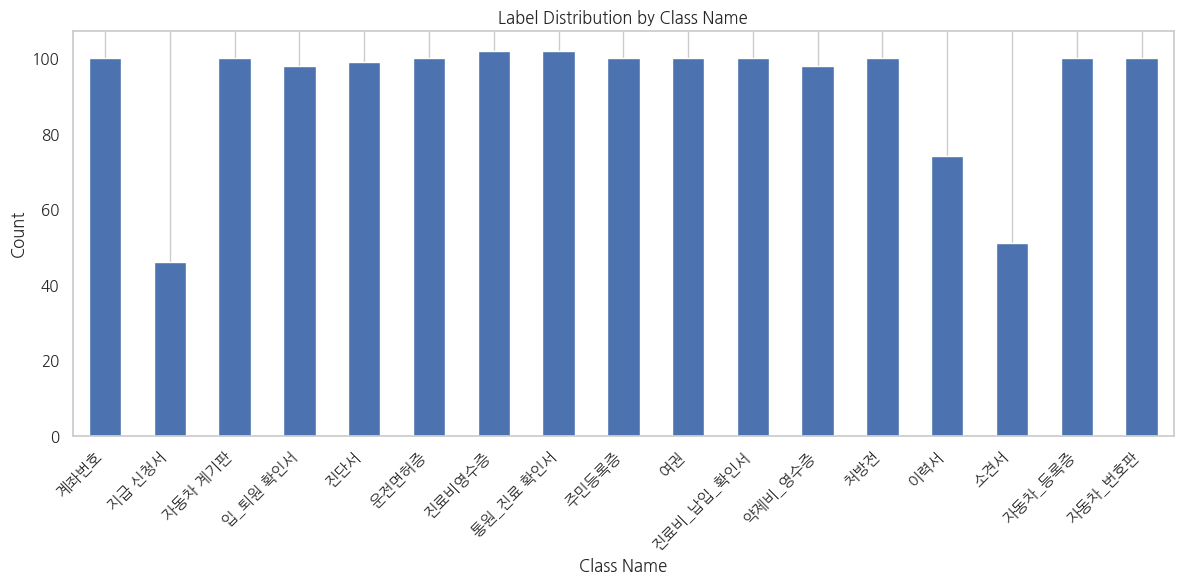

In [85]:
# 기존 코드의 label_dist는 그대로 사용합니다.
label_dist = label_dist.set_index("class_name")

# --- 객체 지향 방식으로 코드 수정 ---
# fig와 ax 객체를 받아옵니다. figsize는 여기서 설정합니다.
fig, ax = plt.subplots(figsize=(12, 6))

# plt.plot() 대신 ax.plot()을 사용합니다.
label_dist["count"].plot(kind='bar', ax=ax)

# plt.xlabel() 대신 ax.set_xlabel()을 사용합니다.
ax.set_xlabel("Class Name")
ax.set_ylabel("Count")
ax.set_title("Label Distribution by Class Name")
ax.grid(axis='y') # grid도 ax 객체에 설정합니다.

# xticks 설정은 plt를 그대로 사용해도 괜찮지만, ax를 사용하는 것이 일관성 있습니다.
# ax.tick_params()를 사용하거나 기존 방식을 유지해도 됩니다.
plt.xticks(rotation=45, ha='right')

# 모든 요소를 그린 후 마지막에 tight_layout을 호출합니다.
fig.tight_layout() # 또는 plt.tight_layout()

plt.show()


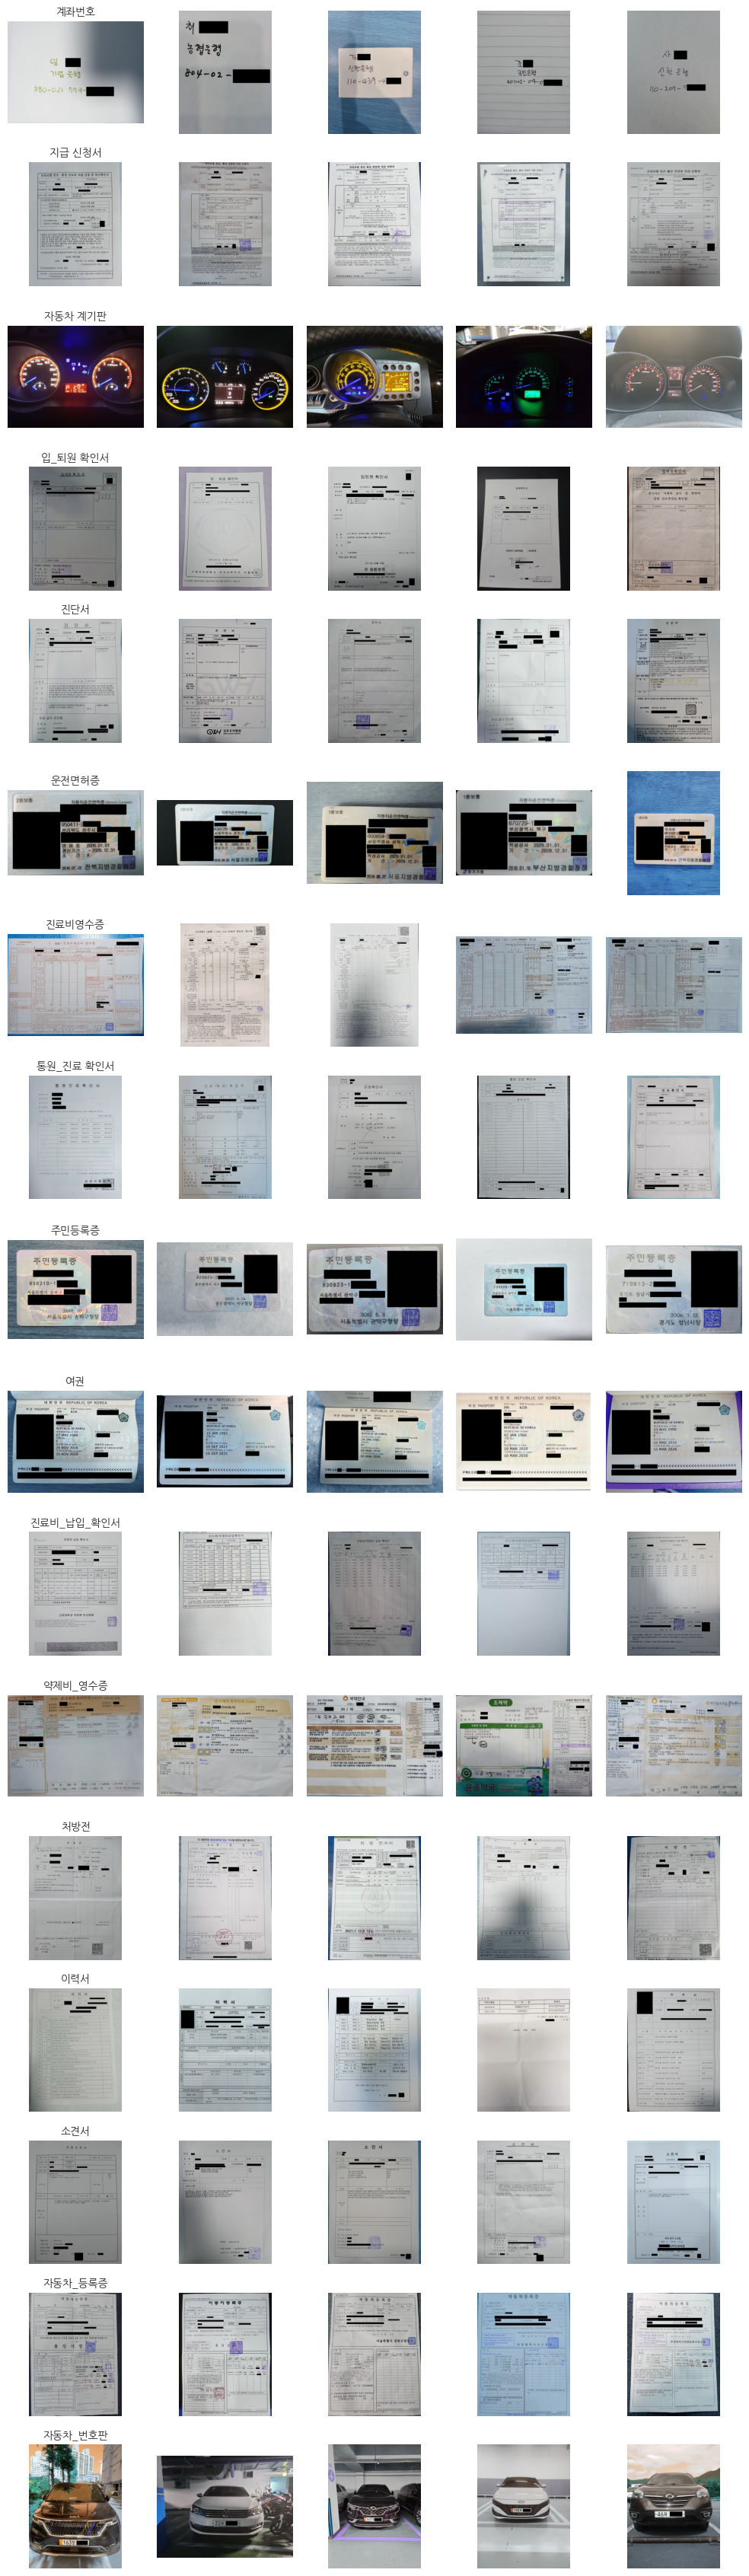

In [86]:
df = pd.read_csv(train_csv_path, header=0)
meta = pd.read_csv(meta_path)  # class 이름이 있는 테이블
class_names = dict(zip(meta["target"], meta["class_name"]))

plot_sample_images(df, image_dir=f"{data_path}/train", class_names=class_names)

In [87]:
# 🔸 1. 사전 준비
model = models.resnet152(weights="IMAGENET1K_V1")
model = torch.nn.Sequential(*list(model.children())[:-1])  # FC 제거
model.eval()

transform = T.Compose([
#     T.Resize((224, 224)),
#     T.ToTensor(),
    T.RandomRotation(degrees=(-10, 10)),  # 약간의 회전
    T.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # 평행이동
    T.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 조정
    T.RandomPerspective(distortion_scale=0.1),  # 원근 변환
    T.Resize((224, 224)),  # 이미지 크기 조정
    T.ToTensor(),  # 이미지를 텐서로 변환
])

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /data/ephemeral/home/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 117MB/s] 


In [88]:
meta = pd.read_csv(meta_path)  # target ↔ class_name
class_name_map = dict(zip(meta["target"], meta["class_name"]))

report_df = analyze_dataset(train_csv_path, train_img_path, model, transform, class_map=class_name_map)
report_df.groupby("class_name")[["sharpness", "noise", "intra_variance"]].mean().sort_values("sharpness")

Class 16: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


,sharpness,noise,intra_variance
class_name,,,
계좌번호,226.210778,38.143516,0.044870
주민등록증,814.745925,77.049693,0.040694
자동차 계기판,855.209435,46.783113,0.106942
운전면허증,1041.723123,80.788961,0.035969
통원_진료 확인서,1080.615317,36.448933,0.029488
소견서,1093.706985,34.009599,0.030327
입_퇴원 확인서,1112.988755,36.826629,0.032482
처방전,1337.848440,33.025083,0.029205
진단서,1387.314683,39.014416,0.024014


In [89]:
generate_quality_report(report_df, save_path="quality_report.pdf")

/root/upstageailab-cv-classification-cv_6/utils/eda_function.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_stats.sort_values("sharpness"), x="sharpness", y="class_name", palette="Blues_r")
/root/upstageailab-cv-classification-cv_6/utils/eda_function.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_stats.sort_values("noise"), x="noise", y="class_name", palette="Reds_r")
/root/upstageailab-cv-classification-cv_6/utils/eda_function.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_stats.sort_val

✅ 리포트 저장 완료: quality_report.pdf


In [90]:
def analyze_image_dimensions_with_meta(image_dir, train_csv, meta_csv):
    df = pd.read_csv(train_csv, header=0)
    meta_df = pd.read_csv(meta_csv)
    class_map = dict(zip(meta_df["target"], meta_df["class_name"]))
    df["class_name"] = df["target"].map(class_map)

    widths, heights, ratios, image_names, targets, class_names = [], [], [], [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="🔍 이미지 크기 스캔 중"):
        img_path = os.path.join(image_dir, row["ID"])
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)
            ratios.append(round(w / h, 2))
            image_names.append(row["ID"])
            targets.append(row["target"])
            class_names.append(row["class_name"])

    stat_df = pd.DataFrame({
        "ID": image_names,
        "target": targets,
        "class_name": class_names,
        "width": widths,
        "height": heights,
        "aspect_ratio": ratios
    })

    return stat_df

In [91]:
size_df = analyze_image_dimensions_with_meta(train_img_path, train_csv_path, meta_path)

# 클래스별 평균 해상도
size_summary = size_df.groupby("class_name")[["width", "height", "aspect_ratio"]].mean().round(1)
print(size_summary.sort_values("width"))

🔍 이미지 크기 스캔 중: 100%|██████████| 1570/1570 [00:03<00:00, 400.33it/s]

            width  height  aspect_ratio
class_name                             
통원_진료 확인서   443.0   591.0           0.8
소견서         443.0   591.0           0.8
진료비_납입_확인서  443.0   591.0           0.8
진단서         443.0   591.0           0.8
지급 신청서      443.0   591.0           0.8
이력서         443.0   591.0           0.8
입_퇴원 확인서    443.0   591.0           0.8
처방전         443.0   591.0           0.8
자동차_등록증     444.5   589.5           0.8
자동차_번호판     475.6   558.4           0.9
계좌번호        483.0   551.0           0.9
진료비영수증      498.1   536.5           1.0
약제비_영수증     521.5   512.5           1.1
자동차 계기판     588.0   446.0           1.3
여권          609.0   432.6           1.4
운전면허증       611.8   431.7           1.4
주민등록증       613.4   431.0           1.4


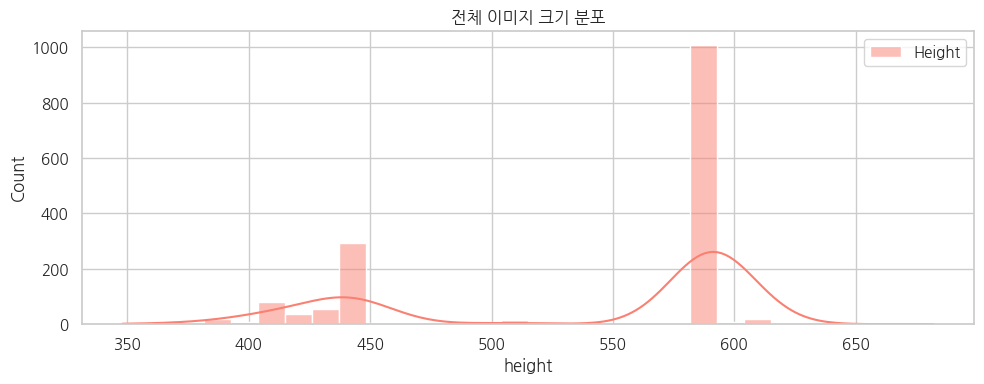

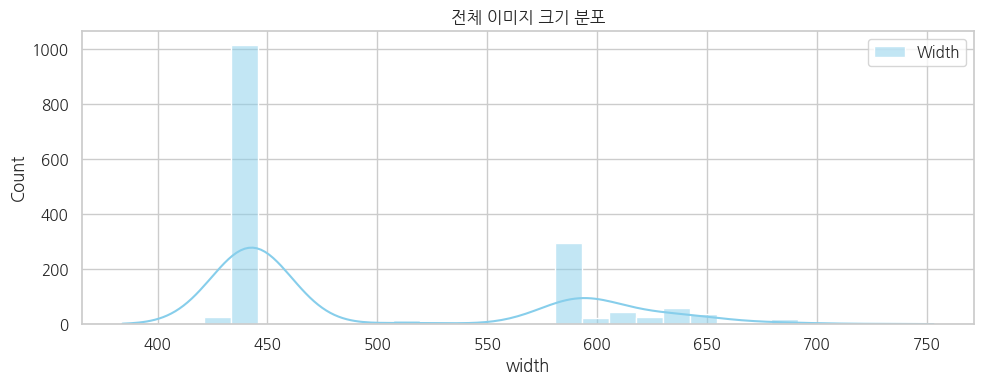

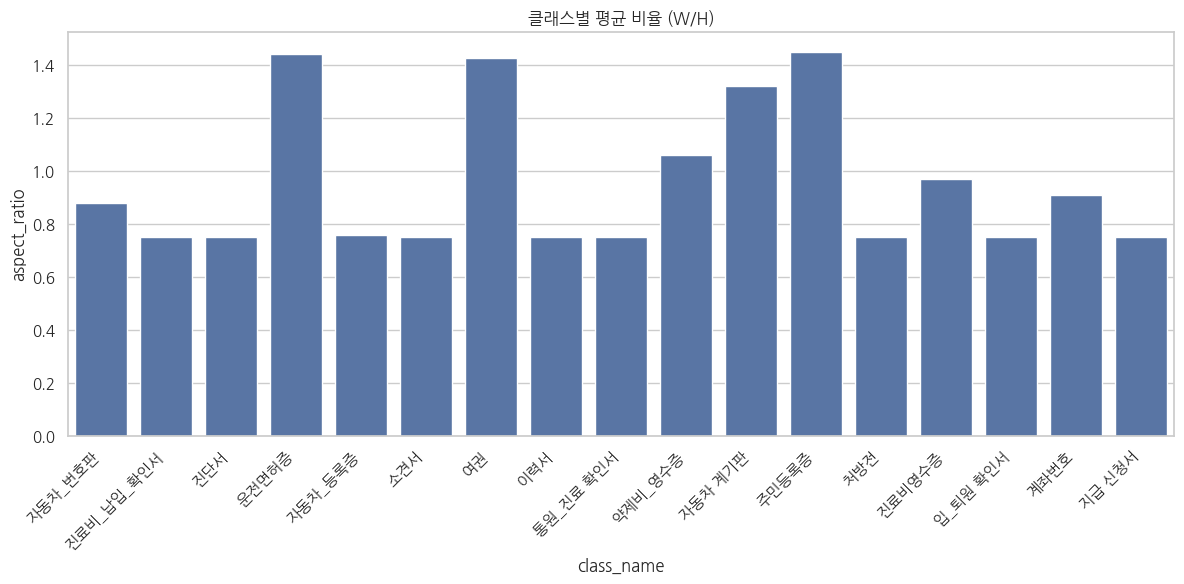

In [92]:
plt.figure(figsize=(10,4))
sns.histplot(size_df["height"], bins=30, color="salmon", label="Height", kde=True)
plt.title("전체 이미지 크기 분포")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
sns.histplot(size_df["width"], bins=30, color="skyblue", label="Width", kde=True)
plt.title("전체 이미지 크기 분포")
plt.legend()
plt.tight_layout()
plt.show()


# 클래스별 평균 비율 막대 그래프
plt.figure(figsize=(12,6))
sns.barplot(data=size_df, x="class_name", y="aspect_ratio", estimator="mean", errorbar=None)
plt.title("클래스별 평균 비율 (W/H)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit

def assign_aspect_bins(df, n_bins=4):
    bins = pd.qcut(df["aspect_ratio"], q=n_bins, labels=False, duplicates='drop')
    df["aspect_bin"] = bins
    df["strata"] = df["target"].astype(str) + "_" + bins.astype(str)
    return df


def debug_strata_distribution(df, strata_col="strata", target_col="target", class_map=None, min_count=2):
    strata_counts = df[strata_col].value_counts().reset_index()
    strata_counts.columns = ["strata", "count"]

    # 클래스 ID, 비율 bin 분리
    strata_counts["target"] = strata_counts["strata"].apply(lambda x: x.split("_")[0])
    strata_counts["aspect_bin"] = strata_counts["strata"].apply(lambda x: x.split("_")[1])

    # 클래스 이름 매핑 (옵션)
    if class_map:
        strata_counts["class_name"] = strata_counts["target"].astype(int).map(class_map)
    else:
        strata_counts["class_name"] = strata_counts["target"]

    # 문제 여부
    strata_counts["problematic"] = strata_counts["count"] < min_count

    return strata_counts.sort_values("count").reset_index(drop=True)


def stratified_split_safely(df, test_size=0.2, n_bins=4, min_count=2, class_map=None, random_state=42):
    # 1. strata 생성
    df = assign_aspect_bins(df, n_bins=n_bins)

    # 2. 디버그 테이블 생성
    strata_dbg = debug_strata_distribution(df, class_map=class_map, min_count=min_count)

    # 3. 문제가 없는 strata만 split 대상으로 사용
    good_strata = strata_dbg[strata_dbg["problematic"] == False]["strata"]
    df_safe = df[df["strata"].isin(good_strata)].reset_index(drop=True)

    # 4. stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(sss.split(df_safe, df_safe["strata"]))
    train_df = df_safe.iloc[train_idx].reset_index(drop=True)
    val_df = df_safe.iloc[val_idx].reset_index(drop=True)

    # 5. 문제 strata는 전부 validation에 수동 포함
    df_problem = df[df["strata"].isin(strata_dbg[strata_dbg["problematic"] == True]["strata"])]
    val_df = pd.concat([val_df, df_problem]).reset_index(drop=True)

    return train_df, val_df, strata_dbg


In [94]:
def compare_split_distributions(train_df, val_df):
    plt.figure(figsize=(10,4))
    sns.kdeplot(train_df["aspect_ratio"], label="Train", fill=True)
    sns.kdeplot(val_df["aspect_ratio"], label="Validation", fill=True)
    plt.title("Aspect Ratio Distribution (Train vs Val)")
    plt.legend()
    plt.show()

,strata,count,target,aspect_bin,class_name,problematic
0,15_1,1,15,1,15,True
1,2_0,2,2,0,2,False
2,9_0,3,9,0,9,False
3,8_0,5,8,0,8,False
4,5_0,6,5,0,5,False
5,6_2,18,6,2,6,False
6,16_1,22,16,1,16,False
7,8_1,25,8,1,8,False
8,6_1,27,6,1,6,False
9,5_1,27,5,1,5,False


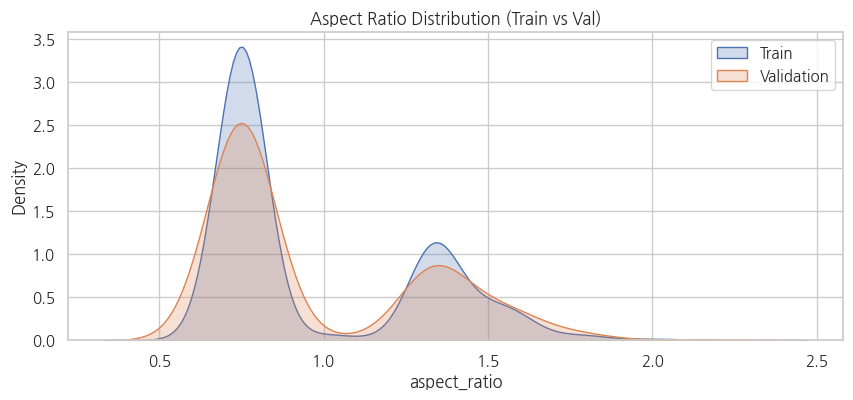

In [95]:
train_df, val_df, strata_dbg = stratified_split_safely(size_df)

display(strata_dbg)

compare_split_distributions(train_df, val_df)

In [96]:
display(train_df)
display(val_df)

,ID,target,class_name,width,height,aspect_ratio,aspect_bin,strata
0,37a79e77c1c3ed6d.jpg,11,약제비_영수증,591,443,1.33,1,11_1
1,3961bbc5ad66a757.jpg,16,자동차_번호판,443,591,0.75,0,16_0
2,c730c8081765dd47.jpg,5,운전면허증,615,425,1.45,2,5_2
3,831e7c40b7700f27.jpg,7,통원_진료 확인서,443,591,0.75,0,7_0
4,7530a83040316e47.jpg,1,지급 신청서,443,591,0.75,0,1_0
...,...,...,...,...,...,...,...,...
1250,267e7c60307fbc40.jpg,12,처방전,443,591,0.75,0,12_0
1251,8b7a49a085e6e092.jpg,16,자동차_번호판,443,591,0.75,0,16_0
1252,a602d3c2110909cc.jpg,3,입_퇴원 확인서,443,591,0.75,0,3_0
1253,afc20ff874b0c11d.jpg,6,진료비영수증,433,604,0.72,0,6_0


,ID,target,class_name,width,height,aspect_ratio,aspect_bin,strata
0,65453fe7b270cd4a.jpg,0,계좌번호,443,591,0.75,0,0_0
1,2e2d105c5a7df767.jpg,4,진단서,443,591,0.75,0,4_0
2,870e37a56286f13c.jpg,13,이력서,443,591,0.75,0,13_0
3,a3252aa9f737d4ec.jpg,10,진료비_납입_확인서,443,591,0.75,0,10_0
4,d24281f1c99057fb.jpg,2,자동차 계기판,591,443,1.33,1,2_1
...,...,...,...,...,...,...,...,...
310,8189f3a50f102070.jpg,2,자동차 계기판,591,443,1.33,1,2_1
311,a29abb626fe9e017.jpg,16,자동차_번호판,591,443,1.33,1,16_1
312,fb366e8a1290169b.jpg,2,자동차 계기판,591,443,1.33,1,2_1
313,be3aed2be00fd713.jpg,4,진단서,443,591,0.75,0,4_0


In [97]:
train_df.to_csv(f"{data_path}/train_valid_set/train-label-fix-v1.csv")
val_df.to_csv(f"{data_path}/train_valid_set/val-v1.csv")

In [98]:
def plot_classwise_aspect_ratio_distribution(df, class_map=None):
    if class_map:
        df["class_name"] = df["target"].map(class_map)

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x="class_name", y="aspect_ratio", palette="Set3")
    plt.xticks(rotation=45, ha="right")
    plt.title("클래스별 Aspect Ratio (W/H) 분포")
    plt.xlabel("클래스명")
    plt.ylabel("Aspect Ratio (Width / Height)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_121167/4191775154.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="class_name", y="aspect_ratio", palette="Set3")


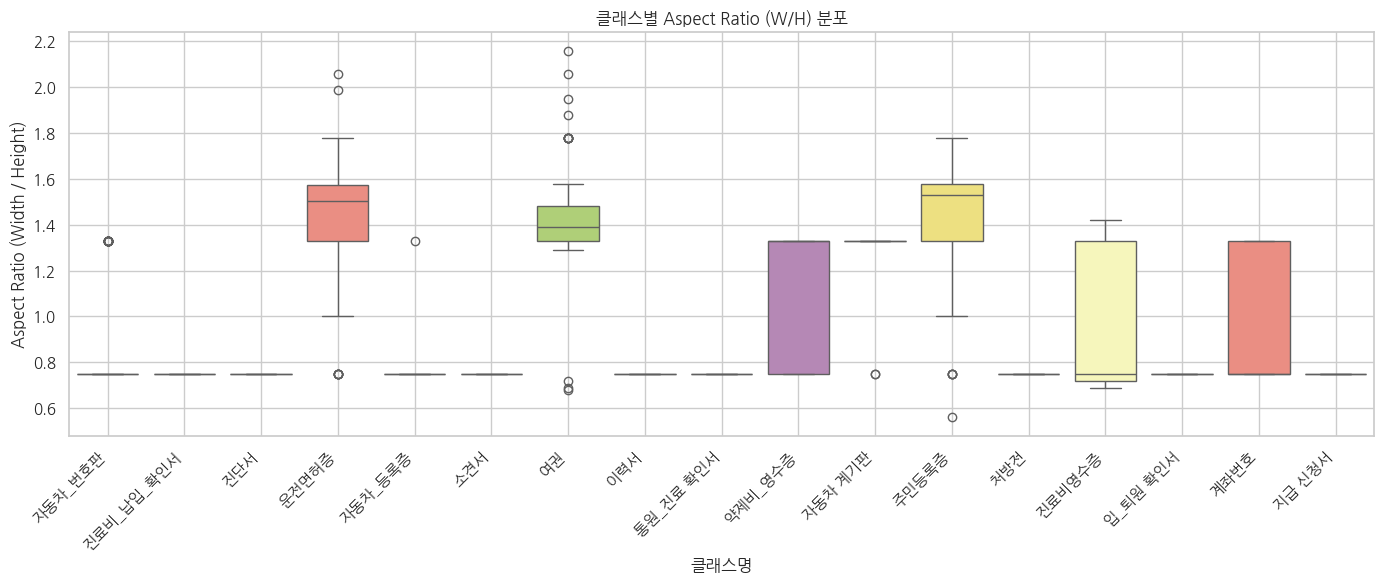

In [99]:
meta_df = pd.read_csv(meta_path)
class_map = dict(zip(meta_df["target"], meta_df["class_name"]))
plot_classwise_aspect_ratio_distribution(size_df, class_map)

In [100]:
def compare_class_distributions(train_df, val_df, class_map=None):
    # target count 계산
    train_counts = train_df["target"].value_counts(normalize=True).sort_index()
    val_counts = val_df["target"].value_counts(normalize=True).sort_index()

    df_plot = pd.DataFrame({
        "target": train_counts.index,
        "train_ratio": train_counts.values,
        "val_ratio": val_counts.values
    })

    # 클래스 이름 추가
    if class_map:
        df_plot["class_name"] = df_plot["target"].map(class_map)
    else:
        df_plot["class_name"] = df_plot["target"].astype(str)

    # Melt해서 Seaborn 시각화 준비
    df_melted = df_plot.melt(id_vars="class_name", value_vars=["train_ratio", "val_ratio"],
                             var_name="dataset", value_name="ratio")

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x="class_name", y="ratio", hue="dataset", palette="Set2")
    plt.title("클래스(target) 분포 비교: Train vs Validation")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("비율 (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

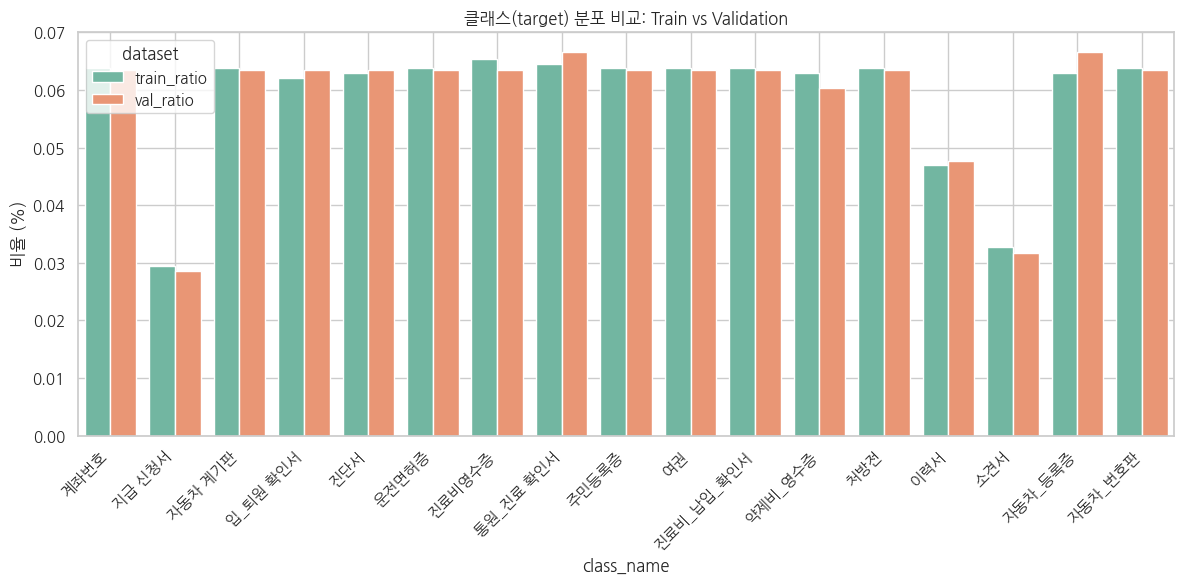

In [101]:
class_map = dict(zip(meta_df["target"], meta_df["class_name"]))

compare_class_distributions(train_df, val_df, class_map)